### Oversampling & prediction on data v2
* SMOTE == r3/r0
* Random forest
* Logistic Reg

In [1]:
#imports
import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import sent_tokenize
from nltk.stem import LancasterStemmer, PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import SMOTE


import re

import matplotlib.pyplot as plt
import seaborn as sns

# import plotly
# import plotly.tools as tls   
# import plotly.graph_objs as go

In [77]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer


In [3]:
import sys
sys.path.append("/Users/Aniket/MyStuff/Study/GreyAtom/Hackathon#3/Hack3_gen_functions")


In [4]:
import Hackathon3GeneralFunctions as genf

In [5]:
from sklearn.model_selection import GridSearchCV


In [6]:
data = pd.read_csv('../../data/train_wo3_stem_tok_ver1.csv')
data_v2 = pd.read_csv('../../data/train_cleaned_v2_wo3.csv')

In [7]:
data.shape

(7148, 5)

#### Check & drop null tweet

In [8]:
data.isnull().sum()

Unnamed: 0    0
tweet_id      0
tweet         0
sentiment     0
tweet_ts      1
dtype: int64

In [9]:
data[data.tweet_ts.isnull() == True]

,Unnamed: 0,tweet_id,tweet,sentiment,tweet_ts
6680,6800,5025,,1,NaN


In [10]:
# data[data.index == 1274]

In [11]:
data = data[data.tweet_ts.isnull() == False ]

In [12]:
data.isnull().sum()

Unnamed: 0    0
tweet_id      0
tweet         0
sentiment     0
tweet_ts      0
dtype: int64

In [13]:
data.shape

(7147, 5)

#### b

In [14]:
data_og = data.copy()

In [15]:
data.tweet.head(10)

0     sxswnui  sxsw  apple defining language of tou...
1    learning ab google doodles  all doodles should...
2    one of the most in your face ex  of stealing t...
3    this iphone  sxsw app would b pretty awesome i...
4    line outside the apple store in austin waiting...
5     technews one lone dude awaits ipad 2 at apple...
6    sxsw tips  prince  npr videos  toy shopping wi...
7    nu user rt   new  ubersocial for  iphone now i...
8            free  sxsw sampler on itunes    freemusic
9    i think i might go all weekend without seeing ...
Name: tweet, dtype: object

In [16]:
data.sentiment.value_counts()

1    4309
2    2382
0     456
Name: sentiment, dtype: int64

In [17]:
data.sentiment.value_counts(normalize=True)*100

1    60.291031
2    33.328669
0     6.380299
Name: sentiment, dtype: float64

#### Data v2 

In [18]:
data_v2.shape

(7149, 6)

In [19]:
data_v2.isnull().sum()

Unnamed: 0       0
tweet_id         0
tweet            1
sentiment        0
tweet_cleaned    1
tweet_stem       2
dtype: int64

In [20]:
data_v2.sentiment.value_counts(normalize=True)*100

1    60.302140
2    33.319345
0     6.378514
Name: sentiment, dtype: float64

In [21]:
data_v2 = data_v2[data_v2.tweet_stem.isnull()==False]
data_v2.shape

(7147, 6)

In [22]:
total_rows = data.shape[0]
print("Rows w/o sent==3: ",total_rows)
#for class 1 = 40%
class1_rows = data.sentiment.value_counts()[1]
print("Rows (class 0) w/o sent==3: ",class1_rows)
total_rows_c1_40 = int(round(class1_rows/0.4))
print("New total Rows total (w/ class 1 = 40%) w/o sent==3: ",total_rows_c1_40)


Rows w/o sent==3:  7147
Rows (class 0) w/o sent==3:  4309
New total Rows total (w/ class 1 = 40%) w/o sent==3:  10772


### ratio 1: 30 40 30


In [23]:
# 4310/.4 #new total Tn1

In [24]:
# Tn1 = 10775 #new total for new ratio
Tn1 = total_rows_c1_40 #new total for new ratio from calculation

ratio_1 = {0:int(round(Tn1*.3)),1:int(round(Tn1*.4)),2:int(round(Tn1*.3))} #new ratio dict
print(ratio_1)
sum(ratio_1.values())
Tn1

{0: 3232, 1: 4309, 2: 3232}


10772

### ratio 2: 20 40 40 


In [25]:
ratio_2 = {0:int(round(Tn1*.2)),1:int(round(Tn1*.4)),2:int(round(Tn1*.4))} #new ratio dict
ratio_2
print(ratio_2)
sum(ratio_2.values())

{0: 2154, 1: 4309, 2: 4309}


10772

### ratio 3: 25 40 35


In [26]:
ratio_3 = {0:int(round(Tn1*.25)),1:int(round(Tn1*.40)),2:int(round(Tn1*.35))} #new ratio dict
ratio_3
print(ratio_3)
sum(ratio_3.values())

{0: 2693, 1: 4309, 2: 3770}


10772

### ratio 4: 20 45 35


In [27]:
# Tn2 = int(round(class0_rows/.45))
# Tn2

In [28]:
# ratio_4 = {0:int(round(Tn2*.20)),1:int(round(Tn2*.45)),2:int(round(Tn2*.35))} #new ratio dict
# ratio_4
# print(ratio_4)
# sum(ratio_4.values())

In [29]:
# X = data.tweet_ts
# # X = data.tweet
# X.shape#[0]*.4

In [30]:
# y = data.sentiment
# y.shape

In [31]:
X = data_v2.tweet_stem
# X = data.tweet
X.shape#[0]*.4

(7147,)

In [32]:
y = data_v2.sentiment
y.shape

(7147,)

In [33]:
# Count vec
cv1 = CountVectorizer(ngram_range=(1, 3))

cv1

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 3), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [34]:
# X_cv1 = genf.vectorizer_fit_transform(cv1,X)
X_cv1 = cv1.fit_transform(X)

In [35]:
X_cv1.shape

(7147, 103333)

#### SMOTE with ratio

In [36]:
# sm3 = SMOTE(random_state=42,sampling_strategy=ratio_1)
# sm3 = SMOTE(random_state=42,sampling_strategy=ratio_3)
sm3 = SMOTE(random_state=42)
X_cv_res3, y_res3 = sm3.fit_resample(X_cv1, y)

In [37]:
y_res3.value_counts(normalize=True)

2    0.333333
1    0.333333
0    0.333333
Name: sentiment, dtype: float64

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_cv_res3, y_res3, train_size=0.8, random_state=10)

In [39]:
# genf.fit_models(X_train3, X_test3, y_train3, y_test3)

In [40]:
model = LogisticRegression(C=100.0,penalty='l2',max_iter=100000)
# model = XGBClassifier()


In [41]:
model.fit(X_train,y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.90      0.80       850
           1       0.73      0.67      0.70       891
           2       0.63      0.53      0.57       845

    accuracy                           0.70      2586
   macro avg       0.69      0.70      0.69      2586
weighted avg       0.69      0.70      0.69      2586



In [43]:
#### Working with test file

In [44]:
test = pd.read_csv('../../data/test_cleaned_v2.csv')

In [45]:
test_sub = test.copy()
test_sub2 = test.copy()

In [46]:
test.shape

(1819, 5)

In [47]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1819 entries, 0 to 1818
Data columns (total 5 columns):
Unnamed: 0       1819 non-null int64
tweet_id         1819 non-null int64
tweet            1819 non-null object
tweet_cleaned    1819 non-null object
tweet_stem       1819 non-null object
dtypes: int64(2), object(3)
memory usage: 71.1+ KB


In [48]:
test.head()

,Unnamed: 0,tweet_id,tweet,tweet_cleaned,tweet_stem
0,0,7506,Audience Q: What prototyping tools do you use?...,audience q what prototyping tools do you use ...,audienc q what prototyp tool do you use sketch...
1,1,7992,At SXSW? Send Your Best Photos &amp; Videos to...,at sxsw send your best photosvideos to ...,at sxsw send your best photosvideo to citizen ...
2,2,247,@mention and here's a pic of you winning your...,and here a pic of you winning your ipad ...,and here a pic of you win your ipad unsix sxsw...
3,3,7688,Google Marissa Mayer: mobile phone as a cursor...,google marissa mayer mobile phone as a cursor...,googl marissa mayer mobil phone as a cursor of...
4,4,3294,#SXSW Google maps is even cooler than I thought,sxsw google maps is even cooler than i thought,sxsw googl map is even cooler than i thought


In [49]:
# test.tweet = test.tweet.map(genf.clean_text)

In [50]:
# test.tweet = test.tweet.map(genf.tokenize_stem_join)

In [51]:

# test.head()

In [52]:
test_cv1 = cv1.transform(test.tweet_stem)

In [53]:
# test_cv1 = pd.DataFrame(test_cv1)

In [54]:
test_cv1.shape

(1819, 103333)

In [55]:
test_sub['sentiment'] = model.predict(test_cv1)

In [56]:
test_sub.head()

,Unnamed: 0,tweet_id,tweet,tweet_cleaned,tweet_stem,sentiment
0,0,7506,Audience Q: What prototyping tools do you use?...,audience q what prototyping tools do you use ...,audienc q what prototyp tool do you use sketch...,1
1,1,7992,At SXSW? Send Your Best Photos &amp; Videos to...,at sxsw send your best photosvideos to ...,at sxsw send your best photosvideo to citizen ...,0
2,2,247,@mention and here's a pic of you winning your...,and here a pic of you winning your ipad ...,and here a pic of you win your ipad unsix sxsw...,0
3,3,7688,Google Marissa Mayer: mobile phone as a cursor...,google marissa mayer mobile phone as a cursor...,googl marissa mayer mobil phone as a cursor of...,1
4,4,3294,#SXSW Google maps is even cooler than I thought,sxsw google maps is even cooler than i thought,sxsw googl map is even cooler than i thought,2


In [57]:
test_sub = test_sub[['tweet_id','sentiment']].set_index('tweet_id')

In [58]:
test_sub.head()

,sentiment
tweet_id,
7506,1
7992,0
247,0
7688,1
3294,2


In [59]:
test_sub.to_csv('new_sub/submission_r0_xg_cv_stem_best_params_v2_FINAL.csv')

In [60]:
tf = TfidfVectorizer(ngram_range=(1, 3))


In [61]:
X_tf = tf.fit_transform(X)

In [62]:
X_tf.shape

(7147, 103333)

In [63]:
# sm3 = SMOTE(random_state=42,sampling_strategy=ratio_3)
# sm3 = SMOTE(random_state=42)
# sm3 = SMOTE(random_state=42,sampling_strategy=ratio_1)

X_tf_res, y_tf_res = sm3.fit_resample(X_tf, y)

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf_res, y_tf_res, train_size=0.8, random_state=10)


In [64]:
model2 = LogisticRegression(C=100.0,penalty='l2',max_iter=100000)
# model2 = XGBClassifier()

model2.fit(X_train_tf,y_train_tf)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
y_pred_tf = model2.predict(X_test_tf)

In [66]:
print(classification_report(y_test_tf, y_pred_tf))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       850
           1       0.87      0.82      0.84       891
           2       0.84      0.86      0.85       845

    accuracy                           0.89      2586
   macro avg       0.89      0.89      0.89      2586
weighted avg       0.89      0.89      0.89      2586



In [67]:
test_tf = tf.transform(test.tweet_stem)

In [68]:
test_sub2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1819 entries, 0 to 1818
Data columns (total 5 columns):
Unnamed: 0       1819 non-null int64
tweet_id         1819 non-null int64
tweet            1819 non-null object
tweet_cleaned    1819 non-null object
tweet_stem       1819 non-null object
dtypes: int64(2), object(3)
memory usage: 71.1+ KB


In [69]:
test_sub2['sentiment'] = model2.predict(test_tf)

In [70]:
test_sub2 = test_sub2[['tweet_id','sentiment']].set_index('tweet_id')

In [71]:
test_sub2.to_csv('new_sub/submission_r0_xg_tf_stem_best_params_v2_FINAL.csv')

In [72]:
# stop

In [73]:
sentiments_desc = { 0: 'Negative', 1: 'Neutral', 2: 'Positive', 3: 'Cannot Tell'}

In [74]:
from sklearn import metrics

pd.DataFrame(metrics.confusion_matrix(y_test_tf, y_pred_tf), columns=['Negative', 'Neutral', 'Positive'], index=['Negative', 'Neutral', 'Positive'])
# , labels=["a", "b", "c"]

,Negative,Neutral,Positive
Negative,849,1,0
Neutral,22,734,135
Positive,6,112,727


In [75]:
y_score = model2.decision_function(X_test)
y_score

array([[-17.94029799,   9.54800722,   8.39229077],
       [ -4.91370724,   9.32867461,  -4.41496736],
       [ -4.91370724,   9.32867461,  -4.41496736],
       ...,
       [ 26.59187269, -16.80984265,  -9.78203004],
       [-16.56856306, -26.12980344,  42.6983665 ],
       [ -4.91370724,   9.32867461,  -4.41496736]])

In [78]:
roc_auc_score(y_test_tf, model2.predict_proba(X_test_tf), multi_class="ovr", average="weighted")

0.9691145293571993

In [79]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
#     y_score = clf.decision_function(X_test)
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

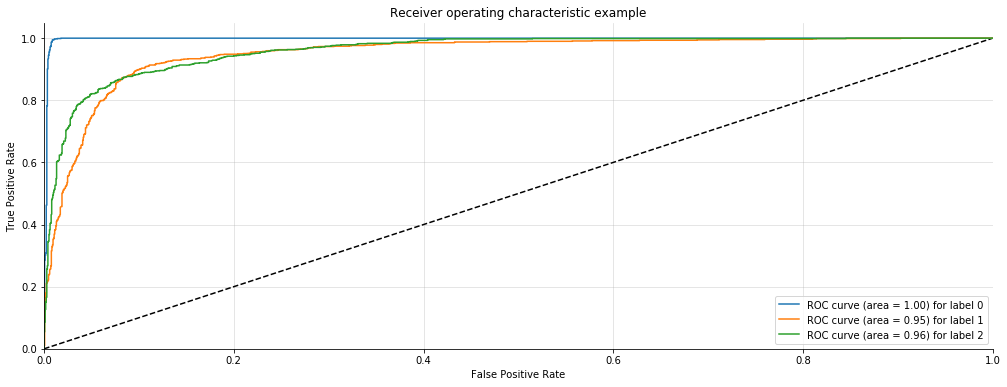

In [80]:
plot_multiclass_roc(model2, X_test_tf, y_test_tf, 3)

In [2]:
# logistic = LogisticRegression()
# logistic

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)